In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import sys

sys.path.append("/content/drive/MyDrive/RL 실습")
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/RL 실습']

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns                                                                                    

from environment import Env

In [4]:
env = Env()
env

In [5]:
#그리드 환경의 기본 정보
print(f"가로: {Env().width}")
print(f"세로: {Env().height}")

가로: 5
세로: 5


In [6]:
#환경의 상태들
Env().get_all_states()[:5]

[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4]]

In [7]:
#환경의 액션
Env().possible_actions

[0, 1, 2, 3]

In [8]:
#행동 후 상태 가져오기
Env().state_after_action([1, 2], 2)

[1, 1]

In [9]:
#환경에서 보상 가져오기 
print("보상 1 : {}".format(Env().get_reward([2, 1], 3)))
print("보상 2 : {}".format(Env().get_reward([2, 0], 3)))

보상 1 : 1
보상 2 : -1


In [10]:
#SARSA 에이전트
class QlearningAgent:
  def __init__(self, env, discount_factor=0.9, lr=1e-1, epsilon=1.0):
    
    self.env = env
    self.q_value_table = np.zeros((env.width, env.height, 4)).tolist()
    self.discount_factor = discount_factor
    self.epsilon = epsilon
    self.lr = lr
    
  def get_action(self, state):
    if np.random.uniform(0, 1, 1) <= self.epsilon:
      return np.random.choice([0, 1, 2, 3], size=1, p=[1/4]*4)[0]

    else:
      q_value_list = []
      for action in self.env.possible_actions:
        q_value = self.q_value_table[state[0]][state[1]][action]
        q_value_list.append(q_value)      
      return np.argmax(q_value_list)

  def update(self, state, action, reward, next_state):
    s, a, r, ns = state, action, reward, next_state

    done = 1 if state == [2,2] else 0

    q_value = self.q_value_table[s[0]][s[1]][a]
    q_max = np.max(self.q_value_table[ns[0]][ns[1]])
    q_target = r + self.discount_factor*q_max*(1-done)
    
    q_value = q_value + self.lr*(q_target-q_value)
    
    self.q_value_table[s[0]][s[1]][a] = q_value

In [11]:
env = Env()
agent = QlearningAgent(env)

In [12]:
#알고리즘 반복
num_eps = 10000
report_every = 1000
rewards = [] 

for i in range(num_eps):
  reward_sum = 0
  state = [0, 0]
  while True:
    action = agent.get_action(state)
    next_state = env.state_after_action(state, action)
    reward = env.get_reward(state, action)

    agent.update(state, action, reward, next_state)
    reward_sum += reward

    state = next_state

    if state == [2, 2]:
      break
  rewards.append(reward_sum)

  if i % report_every == 0:
    print("Running {}th episode".format(i))
    print("Reward sum: {}".format(reward_sum))

Running 0th episode
Reward sum: -2
Running 1000th episode
Reward sum: -1
Running 2000th episode
Reward sum: 1
Running 3000th episode
Reward sum: 0
Running 4000th episode
Reward sum: -2
Running 5000th episode
Reward sum: 0
Running 6000th episode
Reward sum: -2
Running 7000th episode
Reward sum: -8
Running 8000th episode
Reward sum: -3
Running 9000th episode
Reward sum: 0


In [13]:
#그리드 Show 함수
def show(agent_state):

  dis = dict()
  state_len = len(Env().get_all_states())

  terminal_list = [[0,0], [2,2]]
  terminal_idxes = []

  state_idx = Env().get_all_states().index(agent_state)

  for state in range(state_len):
    dis[state] = "o"

  for terminal in terminal_list:
    idx = Env().get_all_states().index(terminal)
    terminal_idxes.append(idx)

  for terminal_idx in terminal_idxes:
    dis[terminal_idx] = "T"

  if state_idx in terminal_idxes:
    dis[state_idx] = "x" 
  else:
    dis[state_idx] = "x" 
  
  grid = ""
  for i in range(state_len):
    if (i+1) % Env().width != 0:
      grid += " " + dis[i]
    else:
      grid += " " + dis[i] + "\n"
  
  return print(grid)

def run():
  state = [0, 0]
  t = 0
  while True:
    t += 1
    four_q = agent.q_value_table[state[0]][state[1]]
    action = np.argmax(four_q)
    next_state = Env().state_after_action(state, action)
    print("{} iteration".format(t))
    show(next_state)
    state = next_state

    if state == [2, 2]:
      break

In [14]:
run()

1 iteration
 T o o o o
 x o o o o
 o o T o o
 o o o o o
 o o o o o

2 iteration
 T o o o o
 o o o o o
 x o T o o
 o o o o o
 o o o o o

3 iteration
 T o o o o
 o o o o o
 o o T o o
 x o o o o
 o o o o o

4 iteration
 T o o o o
 o o o o o
 o o T o o
 o x o o o
 o o o o o

5 iteration
 T o o o o
 o o o o o
 o o T o o
 o o x o o
 o o o o o

6 iteration
 T o o o o
 o o o o o
 o o x o o
 o o o o o
 o o o o o



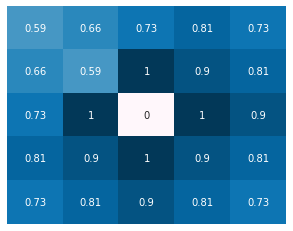

In [15]:
#가치함수 계산
value_tables = np.zeros((Env().width, Env().height)).tolist()

for state in Env().get_all_states():
  four_q = agent.q_value_table[state[0]][state[1]]
  value = np.max(four_q)
  value_tables[state[0]][state[1]] = value

#가치함수 시각화
plt.figure(figsize=(5, 4))
sns.heatmap(value_tables, annot=True, cmap="PuBu", 
            vmin=0, vmax=1, cbar=False)

ax = plt.gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()